# Particles

This notebook trains the diffusion model on a dataset of images of the 2D projections of the energy deposition patterns of four types of particles (electrons, photons, muons and protons) simulated in liquid argon medium. To download this dataset and for more information, see the notebook under datasets/particles.

In [45]:
# Import
from Diffusion import *
from utils import makedir
import torch
from torch.utils.data import Dataset as Dataset
from torch.utils.data import DataLoader as DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from datetime import datetime
import h5py as h5

torch.set_float32_matmul_precision('medium')

In [46]:
# Parameters
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
local_storage_dir = "/home/md775/LocalStorage/MLProjects/Diffusion/" # Change this to your storage directory
dataset_path = local_storage_dir + "Datasets/particles/if-image-train.h5"
checkpoint_dir = local_storage_dir + "Checkpoints/particles/"
log_dir = local_storage_dir + "Logs/particles/"
gif_dir = os.getcwd() + "/gifs/"
makedir(checkpoint_dir)
makedir(log_dir)
makedir(gif_dir)
num_channels = 1 # 1 for grayscale
num_timesteps = 2000 # Number of timesteps of the diffusion process
beta_min = 1e-6
beta_max = 0.99
image_size = 128
batch_size = 32

In [47]:
# Load dataset
class hdf5Dataset(Dataset):
    def __init__(self, dataset_path, load_all=False, transform=None):
        self.transform = transform
        self.dataset_path = dataset_path
        self.load_all = load_all
        if load_all:
            self.dataset = h5.File(dataset_path, 'r')['image'][:]
            self.dataset = self.dataset[:,None,:,:]
            self.dataset = torch.from_numpy(self.dataset).float()
        else:
            self.dataset = h5.File(dataset_path, 'r')['image']

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        if self.load_all:
            image = self.dataset[idx]
        else:
            image = self.dataset[idx][None,:,:]
            image = torch.from_numpy(image).float()
        if self.transform:
            image = self.transform(image)
        return image        

transform = transforms.Resize((image_size, image_size), antialias=True)

image_dataset = hdf5Dataset(dataset_path, load_all=False, transform=transform)
dataloader = DataLoader(image_dataset, batch_size=batch_size, shuffle=True, drop_last=True, num_workers=16, pin_memory=True, persistent_workers=True)

In [48]:
# Create diffusion model
DiffusionModel = Diffusion(
    image_size=image_size,
    num_channels = num_channels,
    num_timesteps=num_timesteps,
    beta_min=beta_min,
    beta_max=beta_max,
    beta_schedule="cosine",
    batch_size=batch_size,
    device=device
)

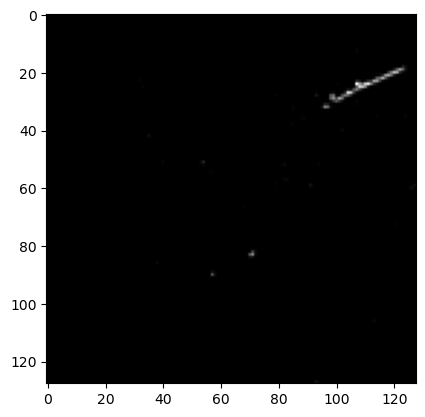

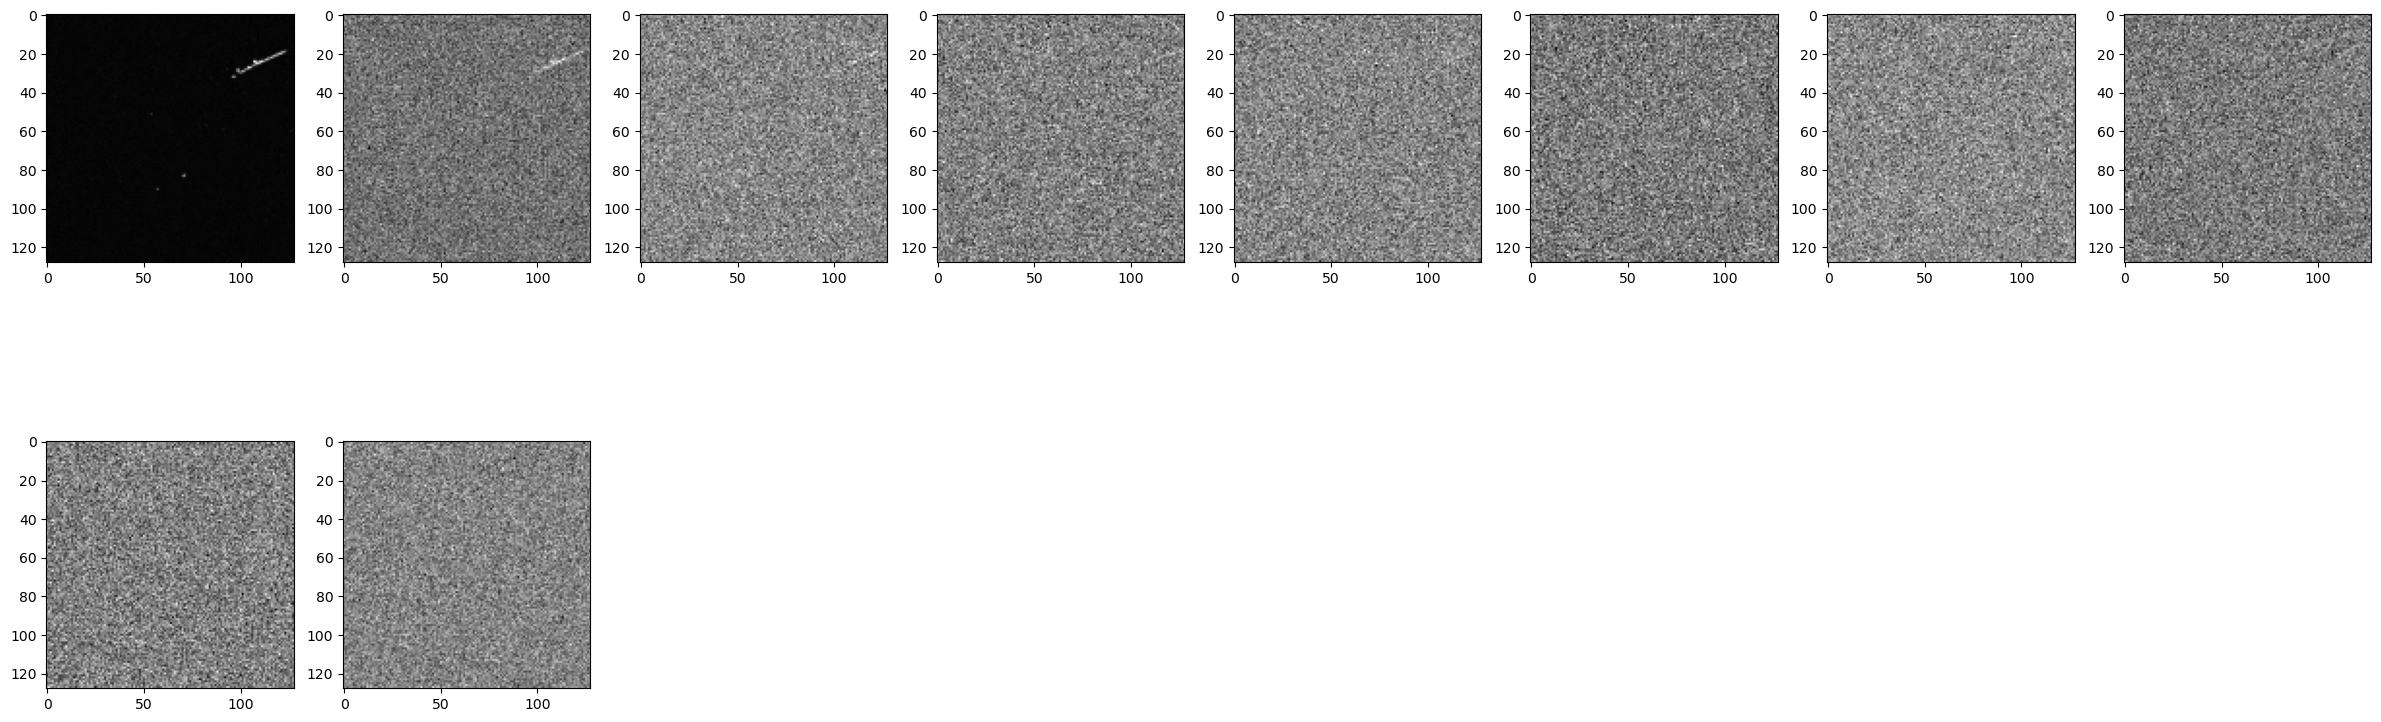

In [49]:
# Visualize forward process
def image_from_tensor(tensor):
    reverse_transforms = transforms.Compose([
        transforms.Lambda(lambda t: t.permute(1, 2, 0)), # CHW to HWC
        transforms.Lambda(lambda t: t.cpu().numpy().astype(np.float32)),
    ])
    return reverse_transforms(tensor)

initial_tensor = next(iter(dataloader)).to(device)
plt.imshow(image_from_tensor(initial_tensor[0]), cmap='gray')

plt.figure(figsize=(30,60))
num_images = 10
stepsize = int(num_timesteps/num_images)
for idx in range(0, num_timesteps, stepsize):
    t = torch.Tensor([idx]).type(torch.int64)
    plt.subplot(int(num_images+1/8)+1, 8, int(idx/stepsize) + 1)
    tensor, noise = DiffusionModel.forward_process(initial_tensor[0,None], t)
    plt.imshow(image_from_tensor(tensor[0]), cmap='gray')

In [50]:
# Create Unet model
model = DiffusionModel.create_model(
    num_init_ch=64,
    num_downsamples=5,
    num_mid_convs=1
    )
print("Num params: ", sum(p.numel() for p in model.parameters()))
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.96, last_epoch=-1, verbose=False)

Num params:  249861889


In [51]:
# Training
def loss_fn(true,pred):
    return F.mse_loss(true, pred) + F.l1_loss(true, pred)

load_from_checkpoint = True
if load_from_checkpoint:
    DiffusionModel.load_from_checkpoint(checkpoint_dir+"model_epoch_45.pt", model, optimizer, lr_scheduler, start_epoch=46)

timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
DiffusionModel.train_model(
    epochs=60,
    data_loader=dataloader,
    model=model,
    optimizer=optimizer,
    lr_scheduler=lr_scheduler,
    loss_function=loss_fn,
    checkpoint_dir=checkpoint_dir,
    checkpoint_interval=5,
    log_dir=log_dir+timestamp
    )

  0%|          | 0/12500 [00:00<?, ?it/s]/home/md775/miniconda3/envs/torch/lib/python3.11/site-packages/torch/overrides.py:110: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  torch.has_cuda,
/home/md775/miniconda3/envs/torch/lib/python3.11/site-packages/torch/overrides.py:111: UserWarning: 'has_cudnn' is deprecated, please use 'torch.backends.cudnn.is_available()'
  torch.has_cudnn,
/home/md775/miniconda3/envs/torch/lib/python3.11/site-packages/torch/overrides.py:117: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  torch.has_mps,
/home/md775/miniconda3/envs/torch/lib/python3.11/site-packages/torch/overrides.py:118: UserWarning: 'has_mkldnn' is deprecated, please use 'torch.backends.mkldnn.is_available()'
  torch.has_mkldnn,
100%|██████████| 12500/12500 [36:53<00:00,  5.65it/s, Epoch:=46, LR:=0.000159, Loss:=0.00687] 


Epoch: 46 Loss: 0.006868687104806304
LR: 0.0001529243769728559


100%|██████████| 12500/12500 [34:29<00:00,  6.04it/s, Epoch:=47, LR:=0.000153, Loss:=0.00688]


Epoch: 47 Loss: 0.006880881047733128
LR: 0.00014680740189394165


100%|██████████| 12500/12500 [34:28<00:00,  6.04it/s, Epoch:=48, LR:=0.000147, Loss:=0.00685]


Epoch: 48 Loss: 0.00685295880138874
LR: 0.000140935105818184


100%|██████████| 12500/12500 [34:29<00:00,  6.04it/s, Epoch:=49, LR:=0.000141, Loss:=0.00685]


Epoch: 49 Loss: 0.006852071122378111
LR: 0.00013529770158545663


100%|██████████| 12500/12500 [34:26<00:00,  6.05it/s, Epoch:=50, LR:=0.000135, Loss:=0.00684]


Epoch: 50 Loss: 0.006840163537748158
LR: 0.00012988579352203836


100%|██████████| 12500/12500 [34:27<00:00,  6.05it/s, Epoch:=51, LR:=0.00013, Loss:=0.00683]


Epoch: 51 Loss: 0.006833940572701394
LR: 0.00012469036178115682


100%|██████████| 12500/12500 [34:26<00:00,  6.05it/s, Epoch:=52, LR:=0.000125, Loss:=0.00683]


Epoch: 52 Loss: 0.00682687116947025
LR: 0.00011970274730991054


100%|██████████| 12500/12500 [34:26<00:00,  6.05it/s, Epoch:=53, LR:=0.00012, Loss:=0.00682]


Epoch: 53 Loss: 0.006815662873499095
LR: 0.00011491463741751412


100%|██████████| 12500/12500 [34:26<00:00,  6.05it/s, Epoch:=54, LR:=0.000115, Loss:=0.0068]


Epoch: 54 Loss: 0.006802802298739552
LR: 0.00011031805192081355


100%|██████████| 12500/12500 [34:25<00:00,  6.05it/s, Epoch:=55, LR:=0.00011, Loss:=0.0068]


Epoch: 55 Loss: 0.006799779757894576
LR: 0.00010590532984398101


100%|██████████| 12500/12500 [34:29<00:00,  6.04it/s, Epoch:=56, LR:=0.000106, Loss:=0.00679]


Epoch: 56 Loss: 0.006791316728293896
LR: 0.00010166911665022177


100%|██████████| 12500/12500 [34:30<00:00,  6.04it/s, Epoch:=57, LR:=0.000102, Loss:=0.0068]


Epoch: 57 Loss: 0.006803450710475445
LR: 9.76023519842129e-05


100%|██████████| 12500/12500 [34:33<00:00,  6.03it/s, Epoch:=58, LR:=9.76e-5, Loss:=0.00678]


Epoch: 58 Loss: 0.006784614184871316
LR: 9.369825790484438e-05


100%|██████████| 12500/12500 [34:31<00:00,  6.03it/s, Epoch:=59, LR:=9.37e-5, Loss:=0.00678]


Epoch: 59 Loss: 0.006775004429630935
LR: 8.99503275886506e-05


100%|██████████| 12500/12500 [34:31<00:00,  6.03it/s, Epoch:=60, LR:=9e-5, Loss:=0.00676]


Epoch: 60 Loss: 0.006760139375329018
LR: 8.635231448510457e-05


In [62]:
# Sample from model
DiffusionModel.load_from_checkpoint(checkpoint_dir+"model_min_loss.pt", model)
tensor_sample = DiffusionModel.sample(num_images=1, variance_coeff=1)

1999it [00:15, 125.82it/s]


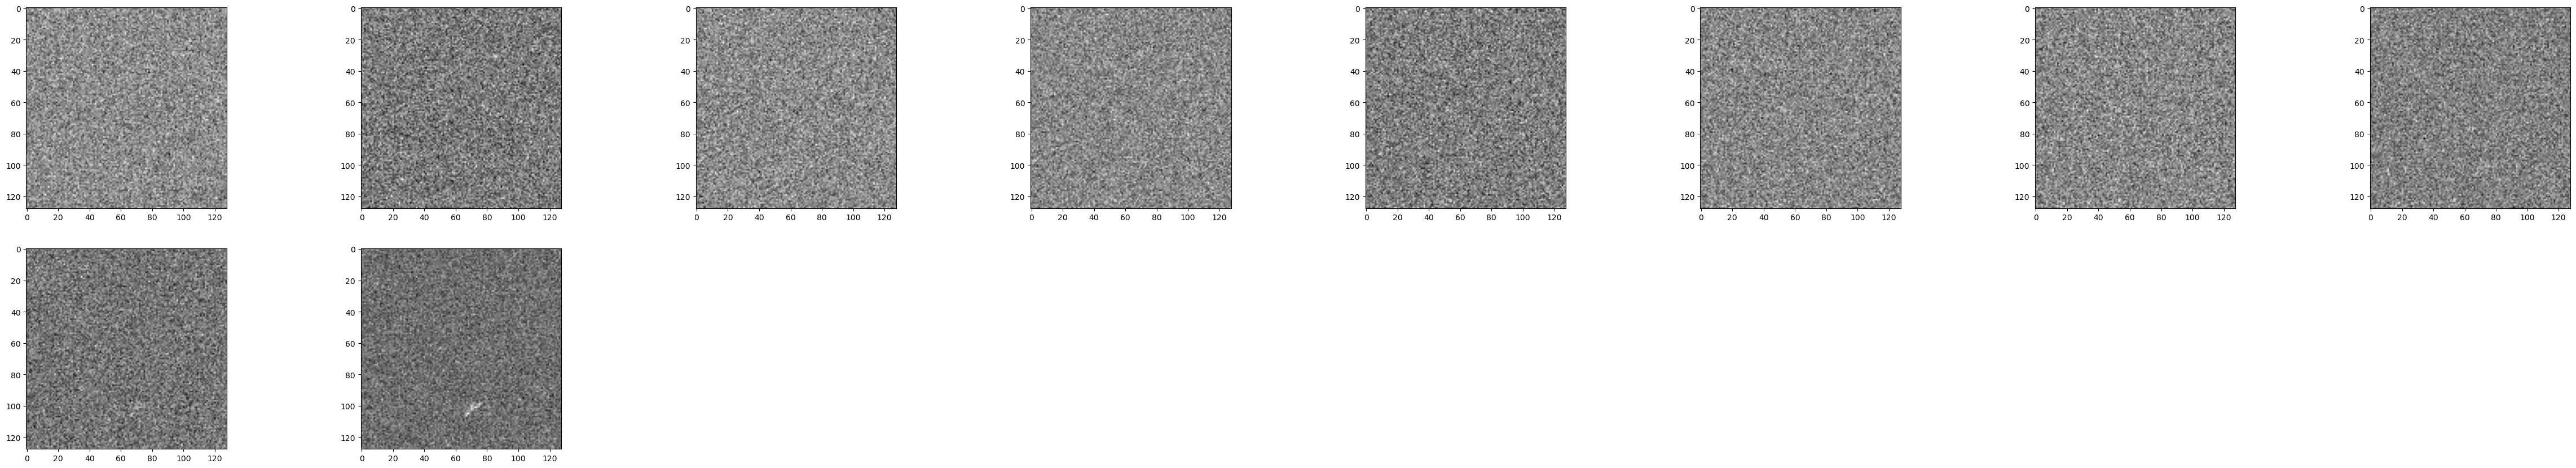

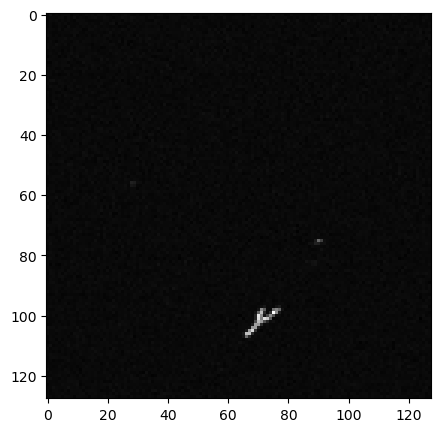

In [63]:
# Visualize reverse process
plt.figure(figsize=(60,60))
num_images = 10
stepsize = int(num_timesteps/num_images)
for i, tensor in enumerate(tensor_sample[0]):
    if i % stepsize == 0:
        plt.subplot(int(num_images+1/8)+1, 8, int(i/stepsize) + 1)
        plt.imshow(image_from_tensor(tensor), cmap='gray')

plt.figure(figsize=(5,5))
plt.imshow(image_from_tensor(tensor_sample[-1][-1]), cmap='gray')

In [64]:
# Create gif
from PIL import Image

def image_from_tensor(tensor):
    reverse_transforms = transforms.Compose([
        transforms.Lambda(lambda t: t.permute(1, 2, 0)), # CHW to HWC
        transforms.Lambda(lambda t: t.cpu().numpy().astype(np.float32)),
        transforms.Lambda(lambda t: t/t.max())
    ])
    return reverse_transforms(tensor)


images = []
num_images = 200
stepsize = int(num_timesteps/num_images)
for t,tensor in enumerate(tensor_sample[0]):
    if t % stepsize == 0:
        plt_figure = plt.figure(figsize=(2,2))
        plt.axis('off')
        plt.imshow(image_from_tensor(tensor), cmap='gray')
        plt_figure.canvas.draw()
        image = Image.frombytes('RGB',plt_figure.canvas.get_width_height(),plt_figure.canvas.tostring_rgb())
        images.append(image)
        plt.close()
images[0].save(gif_dir + '/particles.gif', save_all=True, append_images=images[1:], duration=50)

/tmp/ipykernel_38084/3643176736.py:22: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  image = Image.frombytes('RGB',plt_figure.canvas.get_width_height(),plt_figure.canvas.tostring_rgb())
